Scanning directory: C:\Users\benra\lithk_exp05 for model files matching 'lithk_GIS_MODELNAME_exp05.nc'...
Found 20 model files.

Attempting to load grid dimensions from: C:\Users\benra\lithk_exp05\lithk_GIS_AWI_ISSM1_exp05.nc
Grid dimensions loaded: 577 rows, 337 cols (from AWI_ISSM1's 'lithk' variable).

--- Plotting Individual Model Delta within a Specific Basin ---

Available Models (derived from filenames):
  1. AWI_ISSM1
  2. AWI_ISSM2
  3. AWI_ISSM3
  4. BGC_BISICLES
  5. GSFC_ISSM
  6. ILTS_PIK_SICOPOLIS1
  7. ILTS_PIK_SICOPOLIS2
  8. IMAU_IMAUICE1
  9. IMAU_IMAUICE2
  10. JPL_ISSMPALEO
  11. JPL_ISSM
  12. LSCE_GRISLI
  13. MUN_GSM1
  14. MUN_GSM2
  15. NCAR_CISM
  16. UAF_PISM1
  17. UCIJPL_ISSM1
  18. UCIJPL_ISSM2
  19. VUB_GISM
  20. VUW_PISM

Enter the full name of the model you want to plot (e.g., 'AWI_ISSM1'): UCIJPL_ISSM2

Available Time Windows for Delta Calculation:
  - 2015-2025
  - 2015-2035
  - 2015-2045
  - 2015-2055
  - 2015-2065
  - 2015-2075
  - 2015-2085
  - 20

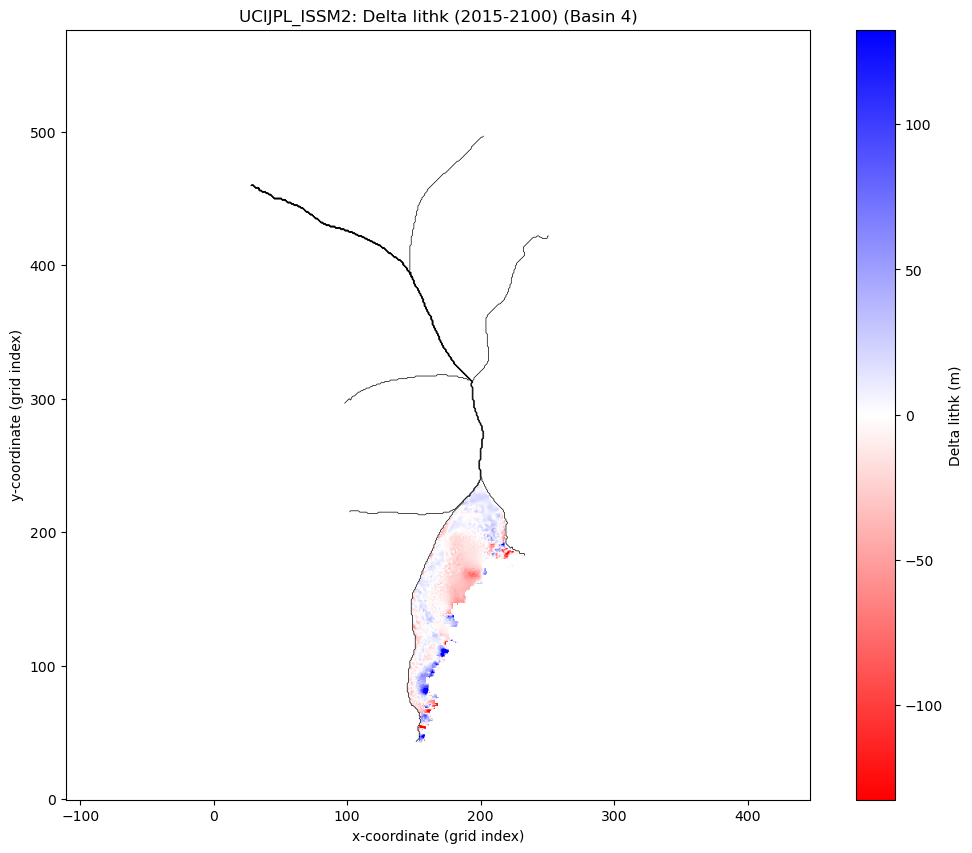


Individual model delta plot within specified basin generated successfully!


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import re
from matplotlib.colors import TwoSlopeNorm

# --- 1. Define Paths and Variables ---
# IMPORTANT: base_dir should point to the folder containing your model NetCDF files
base_dir = r"C:\Users\benra\lithk_exp05" # Path to your folder with NetCDF files
exp_id = 'exp05' # Your experiment ID
var_name = 'lithk' # Variable name

# Define time windows (decades as suggested)
time_windows = {
    '2015-2025': (0, 10),    # indices for 2015-2025
    '2015-2035': (0, 20),    # indices for 2015-2035  
    '2015-2045': (0, 30),    # indices for 2015-2045
    '2015-2055': (0, 40),    # indices for 2015-2055
    '2015-2065': (0, 50),    # indices for 2015-2065
    '2015-2075': (0, 60),    # indices for 2015-2075
    '2015-2085': (0, 70),    # indices for 2015-2085
    '2015-2100': (0, 85)     # full time series
}

# --- 2. Dynamically Identify Models and Load Grid Dimensions ---
all_files_in_dir = os.listdir(base_dir)

models = [] # This will store just the model names
model_filepaths = [] # This will store the full paths to each model's NetCDF file
filename_pattern = re.compile(rf"^{var_name}_GIS_(.*)_{exp_id}\.nc$")

print(f"Scanning directory: {base_dir} for model files matching '{var_name}_GIS_MODELNAME_{exp_id}.nc'...")
for filename in sorted(all_files_in_dir): # Sort for consistent order
    match = filename_pattern.match(filename)
    if match:
        model_name = match.group(1) # Extract the MODELNAME part
        models.append(model_name)
        model_filepaths.append(os.path.join(base_dir, filename))

if not models:
    print(f"Error: No model NetCDF files found in '{base_dir}' matching the pattern '{var_name}_GIS_MODELNAME_{exp_id}.nc'.")
    print("Please ensure 'base_dir', 'var_name', and 'exp_id' are correct, and files follow the expected naming convention.")
    exit()

print(f"Found {len(models)} model files.")

# Load Grid Dimensions (rows, cols) directly from the first lithk data variable
rows, cols = None, None

first_model_filepath_for_dims = model_filepaths[0] # Use the path of the first found model
print(f"\nAttempting to load grid dimensions from: {first_model_filepath_for_dims}")
try:
    with xr.open_dataset(first_model_filepath_for_dims) as temp_ds:
        if var_name in temp_ds:
            lithk_dims = temp_ds[var_name].dims
            lithk_shape = temp_ds[var_name].shape

            y_dim_index = lithk_dims.index('y') if 'y' in lithk_dims else 1 
            x_dim_index = lithk_dims.index('x') if 'x' in lithk_dims else 2 

            rows = lithk_shape[y_dim_index]
            cols = lithk_shape[x_dim_index]
            
            print(f"Grid dimensions loaded: {rows} rows, {cols} cols (from {models[0]}'s '{var_name}' variable).")
        else:
            raise ValueError(f"Variable '{var_name}' not found in {os.path.basename(first_model_filepath_for_dims)}. Cannot determine grid dimensions.")
            
except Exception as e:
    print(f"FATAL ERROR: Could not load grid dimensions from {os.path.basename(first_model_filepath_for_dims)}: {e}")
    print(f"Please inspect this NetCDF file to confirm the '{var_name}' variable exists and has spatial dimensions (y,x).")
    exit()

# --- Load Basin Mask Data (Global variable, loaded once) ---
mask_filepath = r"C:\Users\benra\output_combined_masked_basins.nc"
basin_mask_data = None
unique_basin_ids = [] # To store unique basin IDs for user selection
try:
    with xr.open_dataset(mask_filepath) as mask_ds:
        if 'IDs' in mask_ds:
            basin_mask_data = mask_ds['IDs'].values
            if basin_mask_data.shape != (rows, cols): 
                print(f"Warning: Basin mask dimensions {basin_mask_data.shape} do not match data dimensions {(rows, cols)}. This might cause misalignment.")
            unique_basin_ids = np.unique(basin_mask_data[basin_mask_data > 0]) # Get unique non-zero IDs
        else:
            print(f"Error: Mask variable 'IDs' not found in {os.path.basename(mask_filepath)}. Basin contours will not be plotted.")
            basin_mask_data = None
except Exception as e:
    print(f"Warning: Could not load basin mask from {mask_filepath}: {e}. Basin contours will not be plotted.")
    basin_mask_data = None

# --- 3. Prompt User for Model, Time Window, and Basin ---
print("\n--- Plotting Individual Model Delta within a Specific Basin ---")

# Prompt for Model
print("\nAvailable Models (derived from filenames):")
for i, model_name in enumerate(models):
    print(f"  {i+1}. {model_name}")

chosen_model_name = input("\nEnter the full name of the model you want to plot (e.g., 'AWI_ISSM1'): ").strip()

if chosen_model_name not in models:
    print(f"Error: Model '{chosen_model_name}' not found in the list of available models.")
    exit()

chosen_model_filepath = model_filepaths[models.index(chosen_model_name)]

# Prompt for Time Window
print("\nAvailable Time Windows for Delta Calculation:")
for label in time_windows.keys():
    print(f"  - {label}")

chosen_time_window_label = input("Enter the time window label (e.g., '2015-2100'): ").strip()

if chosen_time_window_label not in time_windows:
    print(f"Error: Time window '{chosen_time_window_label}' not found.")
    exit()

start_idx, end_idx = time_windows[chosen_time_window_label]

# Prompt for Basin ID
if basin_mask_data is not None and len(unique_basin_ids) > 0:
    print(f"\nAvailable Basin IDs: {', '.join(map(str, unique_basin_ids))}")
    try:
        chosen_basin_id_str = input("Enter the Basin ID you want to plot (e.g., '15'): ").strip()
        chosen_basin_id = int(chosen_basin_id_str)
        if chosen_basin_id not in unique_basin_ids:
            raise ValueError("Basin ID not found in the mask data.")
    except ValueError as e:
        print(f"Invalid Basin ID entered: {e}. Please enter an integer from the available IDs.")
        exit()
else:
    print("\nBasin mask data not loaded or no unique basins found. Cannot filter by basin.")
    chosen_basin_id = None # Set to None if no basin can be chosen

# --- 4. Calculate Delta and Apply Basin Mask ---
print(f"\nLoading data for '{chosen_model_name}' and calculating delta for {chosen_time_window_label} within Basin {chosen_basin_id}...")

try:
    with xr.open_dataset(chosen_model_filepath) as model_ds:
        if var_name in model_ds:
            model_data_xr = model_ds[var_name]
        else:
            raise ValueError(f"Variable '{var_name}' not found in {os.path.basename(chosen_model_filepath)}. Please check its name.")

        num_timesteps_in_file = len(model_data_xr['time'])
        if end_idx >= num_timesteps_in_file:
            print(f"Error: End index {end_idx} for window '{chosen_time_window_label}' is out of bounds for {chosen_model_name} (max index is {num_timesteps_in_file - 1}).")
            exit()
        
        if start_idx >= num_timesteps_in_file: 
            print(f"Error: Start index {start_idx} for window '{chosen_time_window_label}' is out of bounds for {chosen_model_name}.")
            exit()

        initial_lithk_2d = model_data_xr.isel(time=0).values
        final_lithk_for_window_2d = model_data_xr.isel(time=end_idx).values
        delta_lithk_2d = final_lithk_for_window_2d - initial_lithk_2d

except Exception as e:
    print(f"ERROR: Failed to load data or calculate delta for {chosen_model_name}: {e}")
    exit()

# Apply the selected basin mask
if chosen_basin_id is not None and basin_mask_data is not None:
    current_basin_2d_mask = (basin_mask_data == chosen_basin_id)
    # Set values outside the chosen basin to NaN
    delta_lithk_2d_masked = np.where(current_basin_2d_mask, delta_lithk_2d, np.nan)
    plot_title_basin_part = f" (Basin {chosen_basin_id})"
else:
    delta_lithk_2d_masked = delta_lithk_2d # Plot full Greenland if no basin selected/available
    plot_title_basin_part = ""
    print("Warning: No basin selected or mask data unavailable. Plotting full Greenland delta.")


# --- 5. Plot the Masked Delta ---
plt.figure(figsize=(12, 10)) 

# Determine min/max for colorbar based on actual masked delta data
# Filter out NaNs for percentile calculation
valid_delta_values = delta_lithk_2d_masked[~np.isnan(delta_lithk_2d_masked)]

upper_percentile_val = np.nanpercentile(np.abs(valid_delta_values), 99) if valid_delta_values.size > 0 else 0
vmin_delta = -upper_percentile_val
vmax_delta = upper_percentile_val

# Fallback for cases where the percentile value is zero (e.g., all deltas are zero or NaN in the basin)
if np.isnan(upper_percentile_val) or upper_percentile_val == 0:
    vmin_delta = -100 
    vmax_delta = 100
    print("Warning: Calculated delta range for the basin is effectively zero or NaN. Using default colorbar range (-100 to 100).")

norm = TwoSlopeNorm(vmin=vmin_delta, vcenter=0, vmax=vmax_delta)

im = plt.imshow(delta_lithk_2d_masked, cmap='bwr_r', origin='lower', norm=norm) 
plt.colorbar(im, label=f'Delta {var_name} (m)') 
plt.xlabel('x-coordinate (grid index)')
plt.ylabel('y-coordinate (grid index)')
plt.title(f'{chosen_model_name}: Delta {var_name} ({chosen_time_window_label}){plot_title_basin_part}')

# Overlay ALL basin contours for context, even if plotting only one basin's data
if basin_mask_data is not None:
    plt.contour(basin_mask_data, levels=np.arange(0.5, 26.5, 1), colors='k', linewidths=0.5, origin='lower')
    print("All basin contours overlaid for context.")
else:
    print("Basin contours could not be overlaid (mask not loaded).")

plt.axis('equal') 
plt.grid(False)
plt.show()

print("\nIndividual model delta plot within specified basin generated successfully!")